# ezomero Demo
# OME Community Meeting 2021

## Before we begin...

For this demo, I am connecting to a JAX OMERO server via our VPN, so you will not be able to follow along exactly.

I am using a MacBook Pro running macOS Catalina, working in a simple conda environment in which I installed:

 * python 3.7
 * ezomero (via pip)
 * jupyterlab (via conda-forge)
 * matplotlib
 
All other dependencies (including OMERO.web) were automatically installed.

## Create a connection

### Create a connection from parameters

In [1]:
# All functions in ezomero have useful docstrings
import ezomero

%pdoc ezomero.connect

Class docstring:
    Create an OMERO connection
    
    This function will create an OMERO connection by populating certain
    parameters for ``omero.gateway.BlitzGateway`` initialization by the
    procedure described in the notes below. Note that this function may
    ask for user input, so be cautious if using in the context of a script.
    
    Finally, don't forget to close the connection ``conn.close()`` when it
    is no longer needed!
    
    Parameters
    ----------
    user : str, optional
        OMERO username.
    
    password : str, optional
        OMERO password.
    
    group : str, optional
        OMERO group.
    
    host : str, optional
        OMERO.server host.
    
    port : int, optional
        OMERO port.
    
    secure : boolean, optional
        Whether to create a secure session.
    
    config_path : str, optional
        Path to directory containing '.ezomero' file that stores connection
        information. If left as ``None``, defaults to th

In [2]:
conn = ezomero.connect(user='djme',
                       group='Research IT',
                       host='bhomero01lp',
                       port=4064,
                       secure=True)

Enter password:  ·············


In [3]:
ezomero.print_groups(conn)

Groups:
                  default: 3	member
                   Public: 53	
       Microscopy_Service: 103	
               Canine_PDX: 104	
               Murray Lab: 105	
             Korstanjelab: 106	
                      MTB: 107	
                 KOMP_eye: 153	member
               Hinson Lab: 203	
              Nishina Lab: 204	
                JAX_Hacks: 253	owner
         Bolcun-Filas Lab: 303	
              Research IT: 304	owner
              Verhaak Lab: 353	owner
           KOMP_histopath: 403	member
                     Cube: 453	
             OConnell Lab: 503	
               Robson Lab: 504	
                Braun Lab: 505	
            Rosenthal Lab: 553	
                      GRS: 603	


In [4]:
print(conn.group)

Research IT


In [5]:
conn.close()

### Create a connection from prompts

In [6]:
conn = ezomero.connect()

Enter username:  djme
Enter password:  ·············
Enter group name (or leave blank for default group):  
Enter host:  bhomero01lp
Enter port:  4064
Secure session (True or False):  t


In [7]:
conn.close()

### Create a connection from stored parameters

In [8]:
ezomero.store_connection_params()

Enter username:  djme
Enter group name (or leave blank for default group):  
Enter host:  bhomero01lp
Enter port:  4064
Secure session (True or False):  t


Connection settings saved to /Users/djme/.ezomero


In [9]:
# Note you still get prompted for password
conn = ezomero.connect()

Enter password:  ·············


In [10]:
conn.close()

### Create a connection from evironment variables

In [11]:
# first remove the stored connection parameters

import os
try:
    os.remove('/Users/djme/.ezomero')
except FileNotFoundError:
    pass
# Setting these using some jupyter magic.
# You wouldn't necessarily do this in practice
%env OMERO_USER=djme
%env OMERO_GROUP=JAX_Hacks
%env OMERO_HOST=bhomero01lp

env: OMERO_USER=djme
env: OMERO_GROUP=JAX_Hacks
env: OMERO_HOST=bhomero01lp


In [12]:
# Since we didn't use all environment variables, we get prompts
conn = ezomero.connect()

Enter password:  ·············
Enter port:  4064
Secure session (True or False):  True


In [13]:
conn.group

'JAX_Hacks'

In [14]:
conn.close()

## Browse OMERO data

In [15]:
conn = ezomero.connect('djme',
                       group='Research IT',
                       host='bhomero01lp',
                       port=4064,
                       secure=True)

Enter password:  ·············


In [16]:
ezomero.print_projects(conn)

Projects:
	test_friday:	501
	zarr:	553
	testdata:	559
	test:	652
	test_auto:	902
	test_auto2:	903
	test_auto1:	904


In [17]:
ezomero.print_datasets(conn, 501)

Datasets in Project "test_friday":
	test_ds_friday:	1456


In [18]:
im_ids = ezomero.get_image_ids(conn, dataset=1456)
print(im_ids)

[24902, 24901]


In [19]:
import numpy as np

# grab an image
im_obj, pix = ezomero.get_image(conn, 24901)
pix.shape  # tzyxc (skimage convention)

(1, 1, 768, 768, 3)

In [20]:
im = np.squeeze(pix)
im.shape

(768, 768, 3)

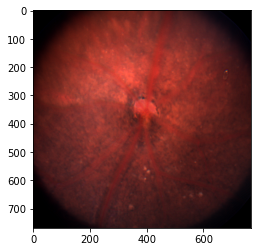

In [21]:
import matplotlib.pyplot as plt
plt.imshow(im);

## Creating Projects, Datasets, and Images

In [22]:
ezomero.print_projects(conn)

Projects:
	test_friday:	501
	zarr:	553
	testdata:	559
	test:	652
	test_auto:	902
	test_auto2:	903
	test_auto1:	904


In [23]:
pid = ezomero.post_project(conn, "OMEdemo2021", description='This is a demo')
print(pid)

913


In [24]:
ezomero.print_projects(conn)

Projects:
	test_friday:	501
	zarr:	553
	testdata:	559
	test:	652
	test_auto:	902
	test_auto2:	903
	test_auto1:	904
	OMEdemo2021:	913


In [25]:
did = ezomero.post_dataset(conn, "test dataset", description='This is our dataset', project_id=pid)
print(did)

2586


In [26]:
ezomero.print_datasets(conn, pid)

Datasets in Project "OMEdemo2021":
	test dataset:	2586


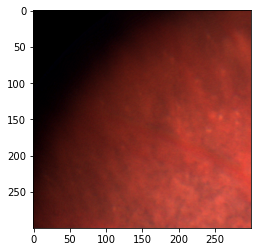

In [27]:
# Crop image
crop_im = im[:300,:300,:]
plt.imshow(crop_im);

In [28]:
crop_im.shape

(300, 300, 3)

In [29]:
# Need to rearrange axes into OMERO style (XYZCT)

omero_im = np.moveaxis(crop_im[:, :, None, :, None], 0, 1)
omero_im.shape

(300, 300, 1, 3, 1)

In [30]:
im_id = ezomero.post_image(conn, omero_im,
                           image_name='gradient_image',
                           dataset_id=did,
                           source_image_id=24901)
ezomero.get_image_ids(conn, did)

[128137]

## Working with MapAnnotations

In [31]:
# The key-value pairs of MapAnnotations are basically dicts
d = {'key1': 'value1',
     'antibody': 'my favorite ab',
     'temp (C)': 27}
ns = 'jax.org/example/namespace'

map_ann_id = ezomero.post_map_annotation(conn, 'Image', im_id, kv_dict=d, ns=ns)
print(map_ann_id)

102287


In [32]:
# Retrieve the MapAnnotation we just posted
map_ann = ezomero.get_map_annotation(conn, map_ann_id)
print(map_ann)

{'key1': 'value1', 'antibody': 'my favorite ab', 'temp (C)': '27'}


In [33]:
# Change a value and update original MapAnnotation
map_ann['temp (C)'] = 25
ezomero.put_map_annotation(conn, map_ann_id, map_ann)
new_map_ann = ezomero.get_map_annotation(conn, map_ann_id)
print(new_map_ann)

{'key1': 'value1', 'antibody': 'my favorite ab', 'temp (C)': '25'}


In [34]:
conn.close()